In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()



In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260210-1636_2q_qst


In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=True)
#session.disconnect()

[2026.02.10 16:41:28.845] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.10 16:41:28.847] INFO    VERSION: laboneq 25.10.3
[2026.02.10 16:41:28.848] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.10 16:41:28.849] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.10 16:41:28.850] INFO    Configuring the device setup
[2026.02.10 16:41:28.851] INFO    The device setup is configured


## 2Q QST Modules Overview

- `experiments.two_qubit_readout_calibration`: `|00>, |01>, |10>, |11>` 상태를 준비해 4x4 readout assignment matrix를 추정합니다.
- `experiments.two_qubit_state_tomography`: `ctrl/targ`를 `|+>`로 준비하고 bus에 고정 RIP를 적용한 뒤 9개 Pauli 설정(XX~ZZ)으로 측정합니다.
- `analysis.two_qubit_state_tomography`: assignment matrix를 포함한 noisy POVM + Cholesky MLE로 `rho`를 복원하고 metric/plot을 생성합니다.

아래 셀은 calibration -> tomography(+analysis) 순서로 실행하는 최소 예시입니다.

[2026.02.10 16:41:28.898] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 16:41:28.899] INFO      Workflow 'two_qubit_readout_calibration': execution started at 2026-02-10     
[2026.02.10 16:41:28.899] INFO      07:41:28.898311Z                                                              
[2026.02.10 16:41:28.899] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 16:41:28.911] INFO    Task 'temporary_qpu': started at 2026-02-10 07:41:28.911078Z
[2026.02.10 16:41:28.912] INFO    Task 'temporary_qpu': ended at 2026-02-10 07:41:28.912135Z
[2026.02.10 16:41:28.915] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-10 
[2026.02.10 16:41:28.916] INFO    07:41:28.915495Z
[2026.02.10 16:41:28.916] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-10 07:41:28.916521Z
[2026.02.10 16:41:28.917] INFO    Task 'temporary_quantum_elements_from_qpu': started

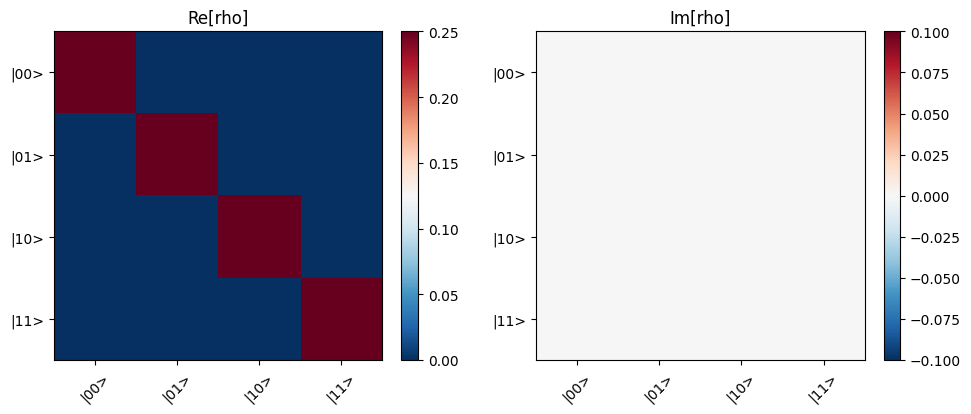

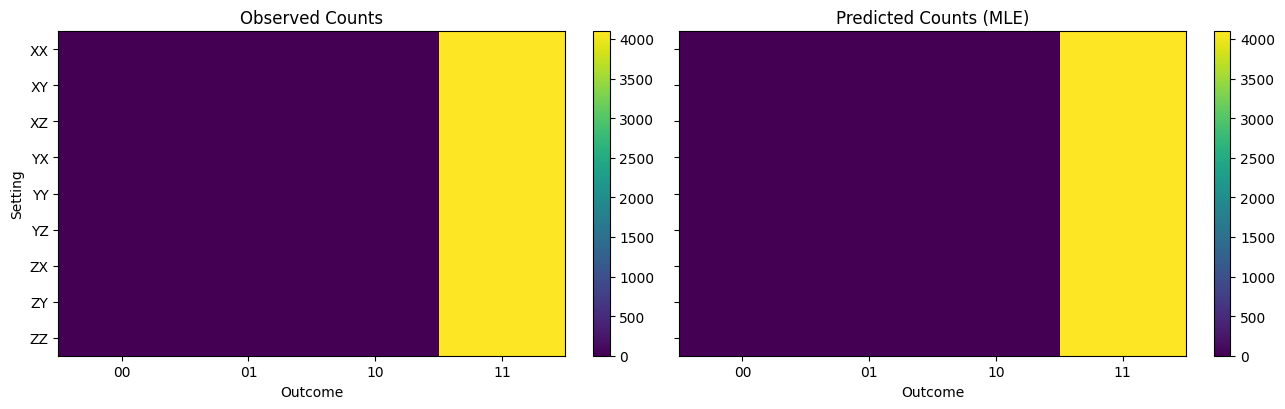

In [6]:
from experiments import two_qubit_state_tomography
from experiments import two_qubit_readout_calibration

# 2Q QST example run (RIP fixed-parameter mode)
ctrl = qubits[0]
targ = qubits[1]
bus = buses[0]
temporary_parameters = {}
c_temp_pars =deepcopy(ctrl.parameters)
t_temp_pars =deepcopy(targ.parameters)
b_temp_pars =deepcopy(bus.parameters)

c_temp_pars.drive_lo_frequency = 4.2e9
t_temp_pars.drive_lo_frequency = 4.2e9
c_temp_pars.readout_lo_frequency = 7.2e9
t_temp_pars.readout_lo_frequency = 7.2e9

c_temp_pars.readout_integration_length = 1.3e-6
t_temp_pars.readout_integration_length = 1.3e-6

temporary_parameters[ctrl.uid] = c_temp_pars
temporary_parameters[targ.uid] = t_temp_pars
temporary_parameters[bus.uid] = b_temp_pars

bus_frequency = (
    bus.parameters.resonance_frequency_bus + (bus.parameters.rip_detuning or 0.0)
    if bus.parameters.resonance_frequency_bus is not None
    else 6.5e9
)
rip_amplitude = float(bus.parameters.rip_amplitude)
rip_length = float(bus.parameters.rip_length)

readout_cal_result = two_qubit_readout_calibration.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    temporary_parameters=temporary_parameters
).run()

tomo_options = two_qubit_state_tomography.experiment_workflow.options()
tomo_options.do_analysis(True)
tomo_options.do_readout_calibration(False)

twoq_qst_result = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=bus,
    bus_frequency=bus_frequency,
    rip_amplitude=rip_amplitude,
    rip_length=rip_length,
    rip_phase=np.pi / 2,
    readout_calibration_result=readout_cal_result,
    target_state="++",
    options=tomo_options,
    temporary_parameters=temporary_parameters
).run()

workflow_output = twoq_qst_result.output
analysis_output = workflow_output.get("analysis_result")
if hasattr(analysis_output, "output"):
    analysis_output = analysis_output.output

print("workflow keys:", list(workflow_output.keys()))
if isinstance(analysis_output, dict):
    print("analysis keys:", list(analysis_output.keys()))
    print("metrics:")
    pprint(analysis_output.get("metrics", {}))


In [7]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=twoq_qst_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)
#plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output, length=250e-6)

[2026.02.10 16:41:29.575] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=10000` to bypass this step with a small impact on the compilation time.
[2026.02.10 16:41:29.578] INFO    Resolved modulation type of oscillator 'b0_drive_osc' on signal 'b0/drive' to HARDWARE
[2026.02.10 16:41:29.578] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'q0/acquire' to SOFTWARE
[2026.02.10 16:41:29.579] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal 'q0/drive' to HARDWARE
[2026.02.10 16:41:29.579] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal 'q0/drive_ef' to HARDWARE
[2026.02.10 16:41:29.579] INFO    Resolved modulation type of oscillator 'q1_readout_acquire_osc' on signal 'q1/acquire' to SOFTWARE
[2026.02.10 16:41:29.579] INFO    Resolved modulation type of oscillator 'q1_drive_ge_osc' on signal 'q1/dr

# SAVE QPU

In [8]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "2q_qst"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")



## 2Q QST Guideline Compliance (STEP-by-STEP)

아래는 `examples/selectiveRIP/2Q_quantum_state_tomography.md` 지침과 현재 구현 코드의 매핑입니다.

**STEP 1. 9개 측정 설정 $s$**

수식/개념:
$$
s \in \{XX,XY,XZ,YX,YY,YZ,ZX,ZY,ZZ\}
$$

코드:
- `experiments/two_qubit_tomography_common.py`의 `TOMOGRAPHY_SETTINGS`
- `experiments/two_qubit_state_tomography.py:create_experiment()` 루프에서 각 setting 실행
- basis pre-rotation은 `_apply_measurement_prerotation()`로 구현

**STEP 2. Assignment matrix $A_{ik}$ calibration**

수식:
$$
A_{ik}=\frac{c_i^{(k)}}{N^{(k)}},\qquad N^{(k)}=\sum_i c_i^{(k)}
$$

코드:
- 실험: `experiments/two_qubit_readout_calibration.py:create_experiment()`
  - 준비 상태: $|00\rangle,|01\rangle,|10\rangle,|11\rangle$
- 분석: `analysis/two_qubit_state_tomography.py:extract_assignment_matrix()`
  - `counts_matrix[:,k] / sum(counts_matrix[:,k])`

**STEP 3. Ideal POVM $E^{ideal}_{s,k}$**

수식:
$$
E^{\mathrm{ideal}}_{s,k}=U_s^\dagger\Pi_k U_s
$$

코드:
- `analysis/two_qubit_state_tomography.py:_computational_projectors_2q()`
- `analysis/two_qubit_state_tomography.py:_single_qubit_prerotation_unitary()`
- `analysis/two_qubit_state_tomography.py:_build_noisy_povm()` 내부에서 `ideal_povm` 생성

**STEP 4. Noisy POVM $E^{meas}_{s,i}$**

수식:
$$
E^{\mathrm{meas}}_{s,i}=\sum_k A_{ik}E^{\mathrm{ideal}}_{s,k}
$$

코드:
- `analysis/two_qubit_state_tomography.py:_build_noisy_povm()`
  - `e_meas += assignment_matrix[i,k] * ideal_povm[k]`

**STEP 5. 확률 모델 $p_{s,i}(\rho)$**

수식:
$$
p_{s,i}(\rho)=\mathrm{Tr}\left(E^{\mathrm{meas}}_{s,i}\rho\right)
$$

코드:
- `analysis/two_qubit_state_tomography.py:_predict_probabilities()`

**STEP 6. 로그우도 최대화(MLE)**

수식:
$$
\log L(\rho)=\sum_{s,i} n_{s,i}\log p_{s,i}(\rho),\qquad
\min -\log L
$$

코드:
- `analysis/two_qubit_state_tomography.py:maximum_likelihood_reconstruct()`
- objective: `-np.sum(counts * np.log(probs))`

**STEP 7. 물리적 상태 파라미터화(Cholesky)**

수식:
$$
\rho(\theta)=\frac{T(\theta)^\dagger T(\theta)}{\mathrm{Tr}(T(\theta)^\dagger T(\theta))}
$$

코드:
- `analysis/two_qubit_state_tomography.py:_theta_to_density_matrix()`
  - lower-triangular 복소 행렬 `T` 구성 후 `T^\dagger T` 정규화

**STEP 8. 검증/후처리**

코드:
- `analysis/two_qubit_state_tomography.py:calculate_state_metrics()`
  - trace, purity, min eigenvalue, Pauli correlators, target fidelity
- `plot_density_matrix()`, `plot_counts()`

**실험 시퀀스(요청사항 반영) 정합성**

현재 `experiments/two_qubit_state_tomography.py`에서 각 setting마다 순서가 아래처럼 강제됩니다:
$$
\text{prep} \rightarrow \text{RIP} \rightarrow \text{basis rotation} \rightarrow \text{measure}
$$

`play_after` 체인으로 겹침을 막도록 구현되어 있습니다.

**참고(지침 대비 구현 선택)**

- readout은 `AcquisitionType.DISCRIMINATION`을 사용해 bit outcome을 직접 수집하고, 이를 count $n_{s,i}$로 변환합니다.
- 기본 shot 수는 현재 설정상 4096(지침 예시 5k~20k보다 낮음)이며, 옵션으로 늘릴 수 있습니다.
